## Data Visualization Notebook

To minimize notebook runtimes, visualizations from the Tropical Storm Classification Project are being run separately here. Notebook contents:

- Correlation matrix: to understand correlations between features

- Pairplot: to visualize how features interact with each other for each class

- Storm map function: to get a look at the courses of the different storms in the dataset

### Recreating Dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio

In [2]:
df = pd.read_csv('data/ibtracs.since1980.list.v04r00.csv', dtype='object', parse_dates=True, skiprows=[1], na_values=' ')
df.columns = [x.lower() for x in df.columns]

In [3]:
#removing unclassified rows
df.drop(df.loc[df['nature'] == 'NR'].index, inplace=True)
df.drop(df.loc[df['nature'] == 'MX'].index, inplace=True)

#new column  
df['target'] = 0

# loop through the data and input a 1 where the storm is a Tropical storm
for row in df.index:
    if df['nature'][row] == 'TS':
        df['target'][row] = 1

In [4]:
initial_feats = ['sid', 'season', 'basin', 'subbasin', 'lat', 'lon', 
                 'wmo_wind', 'dist2land', 'storm_speed', 'storm_dir']
xs_df = df[initial_feats]

xs_df[['lat', 'lon', 'dist2land', 'season', 'wmo_wind', 'storm_speed', 'storm_dir']] = xs_df[['lat', 'lon', 'dist2land', 'season', 'wmo_wind', 'storm_speed', 'storm_dir']].apply(pd.to_numeric)

#taking my datetime object and pulling out the week as a feature
df['iso_time'] = pd.to_datetime(df['iso_time'])
xs_df['week_of_year'] = df['iso_time'].dt.week

In [5]:
y_df = df['target'].to_frame()
clean_df = pd.concat([xs_df, y_df], axis=1)
clean_df.head()

sid  season basin subbasin      lat      lon  wmo_wind  \
0  1980001S13173    1980    SP       MM -12.5000  172.500       NaN   
1  1980001S13173    1980    SP       MM -12.1927  172.441       NaN   
2  1980001S13173    1980    SP       MM -11.9144  172.412       NaN   
3  1980001S13173    1980    SP       MM -11.6863  172.435       NaN   
4  1980001S13173    1980    SP       MM -11.5000  172.500       NaN   

   dist2land  storm_speed  storm_dir  week_of_year  target  
0        647          6.0      351.0             1       1  
1        653          6.0      351.0             1       1  
2        670          5.0      358.0             1       1  
3        682          4.0       12.0             1       1  
4        703          4.0       22.0             1       1

In [6]:
grouped_df = clean_df.groupby(['sid']).max()
grouped_df = grouped_df.reset_index()

In [7]:
grouped_df.head()

sid  season      lat    lon  wmo_wind  dist2land  storm_speed  \
0  1980001S13173    1980 -11.1525  189.5      65.0        934         22.0   
1  1980002S15081    1980 -13.8825   80.0      29.0       2230          7.0   
2  1980003S15137    1980 -14.6600  161.0      50.0        818         26.0   
3  1980005S11059    1980 -11.0000   59.0      25.0       1014         35.0   
4  1980005S14120    1980 -13.6333  120.7     115.0        490         20.0   

   storm_dir  week_of_year  target  
0      358.0             1       1  
1      320.0             1       1  
2      237.0             2       1  
3      308.0             1       1  
4      339.0             2       1

In [8]:
#removing non-numericals
plot_df = clean_df.drop(['subbasin', 'basin'], axis=1)
plot_df.columns

Index(['sid', 'season', 'lat', 'lon', 'wmo_wind', 'dist2land', 'storm_speed',
       'storm_dir', 'week_of_year', 'target'],
      dtype='object')

### Feature Exploration Visualizations

#### Correlation Marix

(9, 0)

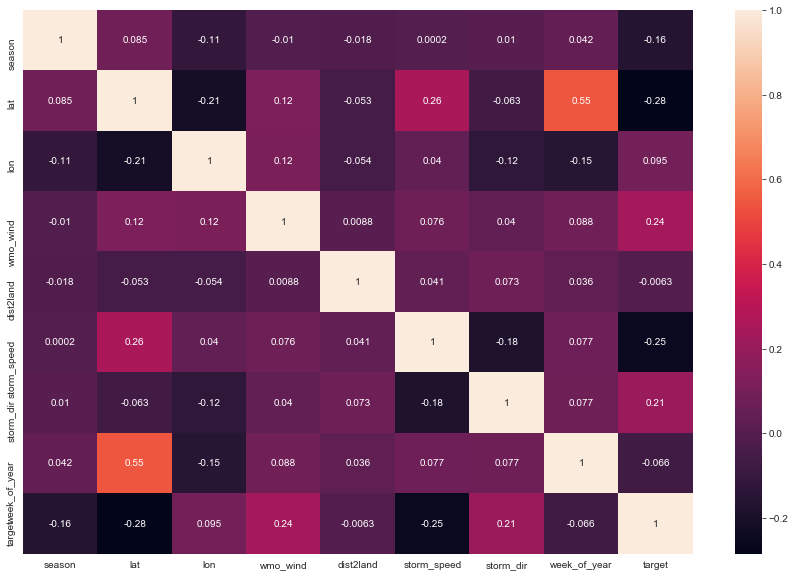

In [9]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(plot_df.corr(), annot=True)
ax.set_ylim(9,0)

# plt.savefig('images/correlation_matrix')

#### Pairplot

<Figure size 720x576 with 0 Axes>

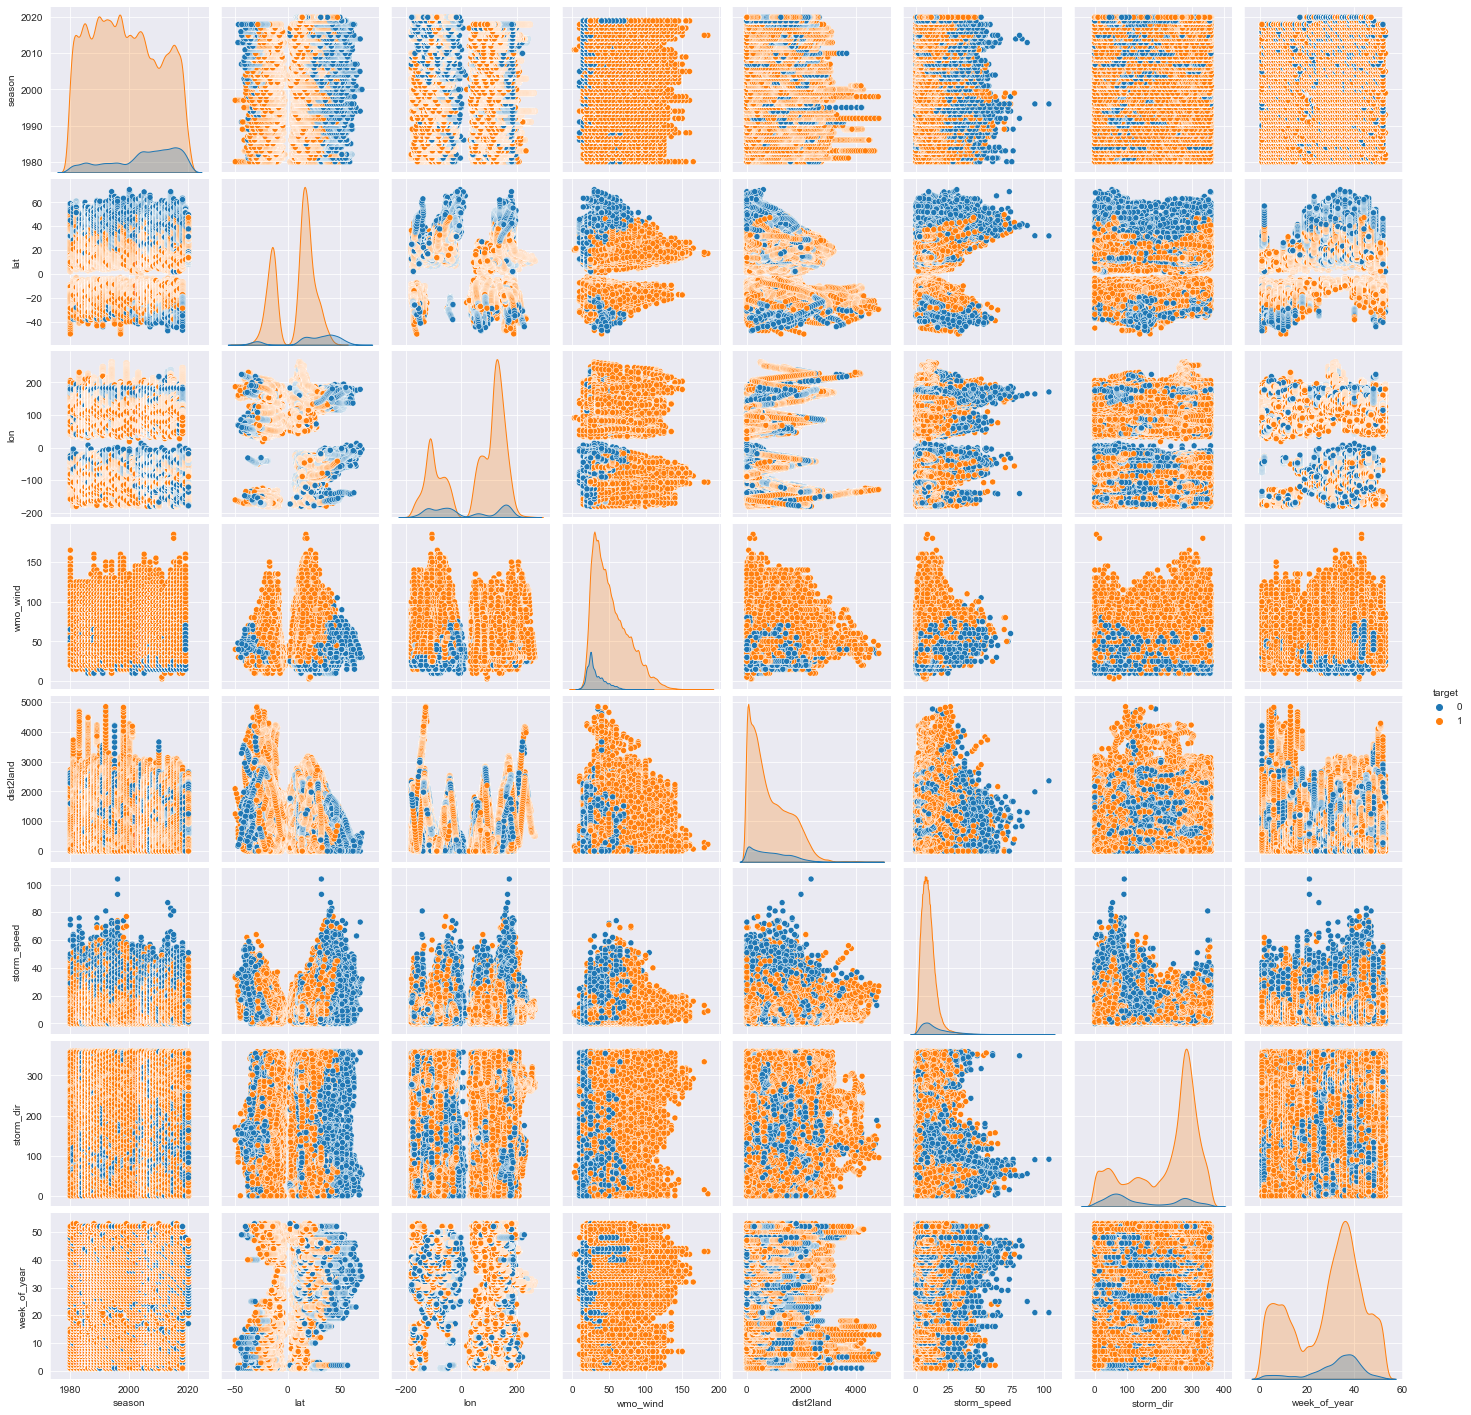

In [10]:
plt.figure(figsize=(10,8))

sns.pairplot(plot_df, hue='target')

# plt.savefig('images/pairplot')

### Mapping Storms with Plotly

In [11]:
map_df = clean_df[['sid', 'lat', 'lon', 'season', 'week_of_year', 'target']]

In [12]:
map_df['sid'].nunique()

3912

In [13]:
map_df.head()

sid      lat      lon  season  week_of_year  target
0  1980001S13173 -12.5000  172.500    1980             1       1
1  1980001S13173 -12.1927  172.441    1980             1       1
2  1980001S13173 -11.9144  172.412    1980             1       1
3  1980001S13173 -11.6863  172.435    1980             1       1
4  1980001S13173 -11.5000  172.500    1980             1       1

In [14]:
#singular function as test

# test_table = map_df.loc[map_df['sid'] == grouped_df['sid'][0]]
# test_table.head()

#fig = px.line_mapbox(test_table, lat="lat", lon="lon", color="target", zoom=3, height=300)

# fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=2,
#     margin={"r":0,"t":0,"l":0,"b":0})

# fig.show()

# pio.write_image(fig, 'images/storm_map.jpg', format='jpg')

In [15]:
def plot_storm(index):
    """
    This function allows the user to input a specific storm to visualize its course on a map. 
    The user must choose the storm by grabbing its index from the grouped_df in this notebook. 
    The index is the only input needed. The zoom may be adjusted in the run function
    """

    table = map_df.loc[map_df['sid'] == grouped_df['sid'][index]]

    fig = px.line_mapbox(table, lat='lat', lon='lon',
                         color="target", zoom=1, height=300)

    fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=4, mapbox_center_lat=table['lat'].mean(),
                      margin={"r": 0, "t": 0, "l": 0, "b": 0})

    fig.show()

In [16]:
plot_storm(2)